In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)

# 1. Hyper-parameters & settings

In [2]:
BATCH_SIZE    = 32
EPOCHS        = 50
LR            = 1e-3
MAX_LEN       = 1000
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compartments shared between train & test
LABEL_COLS = [
    'Cell membrane',
    'Cytoplasm',
    'Endoplasmic reticulum',
    'Golgi apparatus',
    'Lysosome/Vacuole',
    'Mitochondrion',
    'Nucleus',
    'Peroxisome',
]

# Amino‐acid → index mapping (0 will be the PAD token)
AA_LIST   = list("ACDEFGHIKLMNPQRSTVWY")
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AA_LIST)}

# 2. Sequence encoding

In [3]:
def encode_seq(seq, max_len=MAX_LEN):
    # truncate
    seq = seq[:max_len]
    # map to indices, unknown → 0
    idxs = [AA_TO_IDX.get(residue, 0) for residue in seq]
    # pad
    if len(idxs) < max_len:
        idxs.extend([0] * (max_len - len(idxs)))
    return torch.tensor(idxs, dtype=torch.long)

# 3. Dataset & DataLoader

In [4]:
class ProteinDataset(Dataset):
    def __init__(self, df, label_cols, seq_col='Sequence'):
        self.seqs   = df[seq_col].values
        self.labels = df[label_cols].values.astype(np.float32)

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        x = encode_seq(self.seqs[idx])
        y = torch.tensor(self.labels[idx])
        return x, y

def collate_fn(batch):
    seqs, labels = zip(*batch)
    seqs_tensor  = torch.stack(seqs)
    labels_tensor= torch.stack(labels)
    return seqs_tensor, labels_tensor

# 4. Load CSVs

In [5]:
train_df = pd.read_csv('data/Swissprot_Train_Validation_dataset.csv')
test_df  = pd.read_csv('data/hpa_testset.csv')

# rename HPA 'fasta' → 'Sequence'
test_df = test_df.rename(columns={'fasta':'Sequence'})

# keep only the columns we care about
train_df = train_df[['Sequence'] + LABEL_COLS]
test_df  = test_df [['Sequence'] + LABEL_COLS]

train_dataset = ProteinDataset(train_df, LABEL_COLS)
test_dataset  = ProteinDataset(test_df,  LABEL_COLS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn)

# 5. Model, loss, optimizer

In [6]:
class DeepLocModel(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 num_classes: int,
                 emb_dim: int = 20,
                 seq_len: int = 1000,
                 filter_sizes=(1,3,5,9,15,21),
                 num_filters: int = 20,
                 lstm_hidden: int = 256,
                 attn_units: int = 256,
                 dec_steps: int = 10):
        super().__init__()
        # 1) Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        # 2) Motif‐detector convolutions
        #   6 filter sizes × 20 each = 120 output channels
        self.convs = nn.ModuleList([
            nn.Conv1d(emb_dim, num_filters, k, padding=k//2)
            for k in filter_sizes
        ])
        # another conv: 128 filters of size 3 over the 120‐dim map
        self.conv2 = nn.Conv1d(num_filters * len(filter_sizes),
                               128, kernel_size=3, padding=1)

        # 3) Bidirectional LSTM encoder
        self.encoder = nn.LSTM(input_size=128,
                               hidden_size=lstm_hidden,
                               num_layers=1,
                               batch_first=True,
                               bidirectional=True)

        # 4) Attentive decoder
        #   LSTMCell with 512 hidden units, run for D=10 steps
        self.dec_steps = dec_steps
        dec_input_dim = lstm_hidden*2 + lstm_hidden*2  # h_L (512) + c_prev (512)
        self.decoder = nn.LSTMCell(dec_input_dim, lstm_hidden*2)

        # Attention FFN: W_e, W_d → 256 units, then v → scalar score
        self.W_e = nn.Linear(lstm_hidden*2, attn_units, bias=False)
        self.W_d = nn.Linear(lstm_hidden*2, attn_units, bias=False)
        self.v   = nn.Linear(attn_units, 1, bias=False)

        # learned initial context vector c0
        self.c0 = nn.Parameter(torch.zeros(lstm_hidden*2))

        # 5) Classification head
        self.fc        = nn.Linear(lstm_hidden*2, lstm_hidden*2)
        self.classifier= nn.Linear(lstm_hidden*2, num_classes)

    def forward(self, x):
        # x: (batch, seq_len) of token indices
        batch_size = x.size(0)

        # Embedding + convs
        emb = self.embedding(x)                   # (B, L, emb_dim)
        emb = emb.transpose(1, 2)                 # → (B, emb_dim, L)
        conv_outs = [F.relu(conv(emb)) for conv in self.convs]
        h = torch.cat(conv_outs, dim=1)           # (B, 120, L)
        h = F.relu(self.conv2(h))                 # (B, 128, L)

        # Encode with Bi-LSTM
        h = h.transpose(1, 2)                     # → (B, L, 128)
        enc_out, (hn, cn) = self.encoder(h)
        # final encoder hidden state h_L for decoder input
        h_forward  = hn[-2]                       # (B, 256)
        h_backward = hn[-1]                       # (B, 256)
        h_L = torch.cat([h_forward, h_backward], dim=1)  # (B, 512)

        # Attentive decoding for D steps
        # init decoder hidden & cell to zeros
        d_h = torch.zeros(batch_size, h_L.size(1), device=x.device)
        d_c = torch.zeros_like(d_h)
        # init context to learned c0
        c_prev = self.c0.unsqueeze(0).expand(batch_size, -1)

        for _ in range(self.dec_steps):
            # input = [h_L; c_prev]
            dec_in = torch.cat([h_L, c_prev], dim=1)
            d_h, d_c = self.decoder(dec_in, (d_h, d_c))

            # compute attention scores over time steps
            # enc_out: (B, L, 512), d_h: (B, 512)
            # W_e(enc_out) → (B, L, attn_units)
            # W_d(d_h)    → (B, attn_units) → unsqueeze(1) → (B, 1, attn_units)
            e = torch.tanh(
                self.W_e(enc_out) +
                self.W_d(d_h).unsqueeze(1)
            )                                       # (B, L, attn_units)
            scores = self.v(e).squeeze(-1)          # (B, L)
            α = F.softmax(scores, dim=1)            # (B, L)

            # context = weighted sum of encoder outputs
            c_prev = torch.bmm(α.unsqueeze(1), enc_out).squeeze(1)  # (B, 512)

        # final classification
        out = F.relu(self.fc(c_prev))             # (B, 512)
        logits = self.classifier(out)              # (B, num_classes)

        return logits

In [7]:
model     = DeepLocModel(vocab_size=len(AA_TO_IDX)+1,
                    num_classes=len(LABEL_COLS)).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 6. Training loop

In [8]:
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(DEVICE), labels.to(DEVICE)
        logits = model(seqs)                    # (B, num_classes)
        loss   = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seqs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"[Epoch {epoch:2d}/{EPOCHS}] Train Loss: {epoch_loss:.4f}")

[Epoch  1/50] Train Loss: 0.3223
[Epoch  2/50] Train Loss: 0.2744
[Epoch  3/50] Train Loss: 0.2586
[Epoch  4/50] Train Loss: 0.2455
[Epoch  5/50] Train Loss: 0.2375
[Epoch  6/50] Train Loss: 0.2293
[Epoch  7/50] Train Loss: 0.2225
[Epoch  8/50] Train Loss: 0.2151
[Epoch  9/50] Train Loss: 0.2074
[Epoch 10/50] Train Loss: 0.1985
[Epoch 11/50] Train Loss: 0.1904
[Epoch 12/50] Train Loss: 0.1813
[Epoch 13/50] Train Loss: 0.1708
[Epoch 14/50] Train Loss: 0.1608
[Epoch 15/50] Train Loss: 0.1502
[Epoch 16/50] Train Loss: 0.1381
[Epoch 17/50] Train Loss: 0.1278
[Epoch 18/50] Train Loss: 0.1164
[Epoch 19/50] Train Loss: 0.1085
[Epoch 20/50] Train Loss: 0.0946
[Epoch 21/50] Train Loss: 0.0855
[Epoch 22/50] Train Loss: 0.0780
[Epoch 23/50] Train Loss: 0.0697
[Epoch 24/50] Train Loss: 0.0637
[Epoch 25/50] Train Loss: 0.0609
[Epoch 26/50] Train Loss: 0.0538
[Epoch 27/50] Train Loss: 0.0502
[Epoch 28/50] Train Loss: 0.0470
[Epoch 29/50] Train Loss: 0.0469
[Epoch 30/50] Train Loss: 0.0412
[Epoch 31/

# 7. Evaluation on HPA test set

In [9]:
model.eval()
all_preds  = []
all_labels = []

with torch.no_grad():
    for seqs, labels in test_loader:
        seqs = seqs.to(DEVICE)
        logits = model(seqs)
        probs  = torch.sigmoid(logits).cpu().numpy()
        preds  = (probs > 0.5).astype(int)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds  = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

## Binary confusion matrices for each class

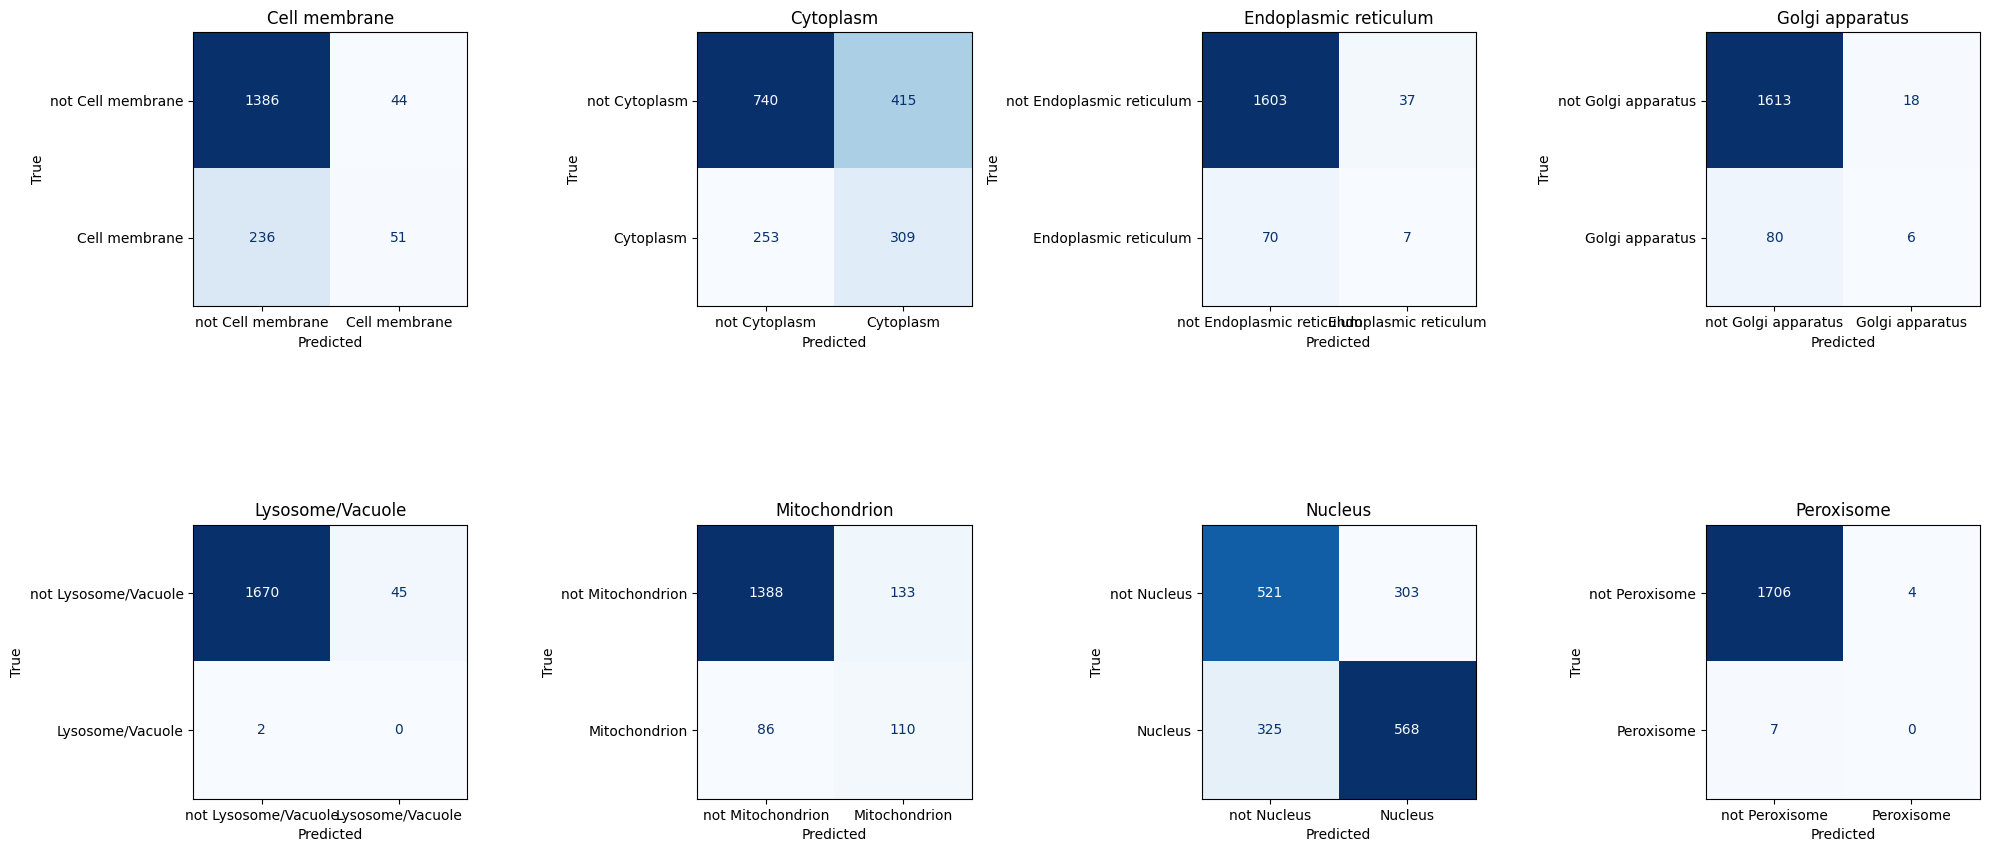

In [14]:
# Create a 2×4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, cls in enumerate(LABEL_COLS):
    # compute binary CM for this class
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i], labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[f'not {cls}', cls]
    )
    # plot into the i-th axis, without individual colorbars
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(cls)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

## Multi-class confusion matrix (exact‐match)

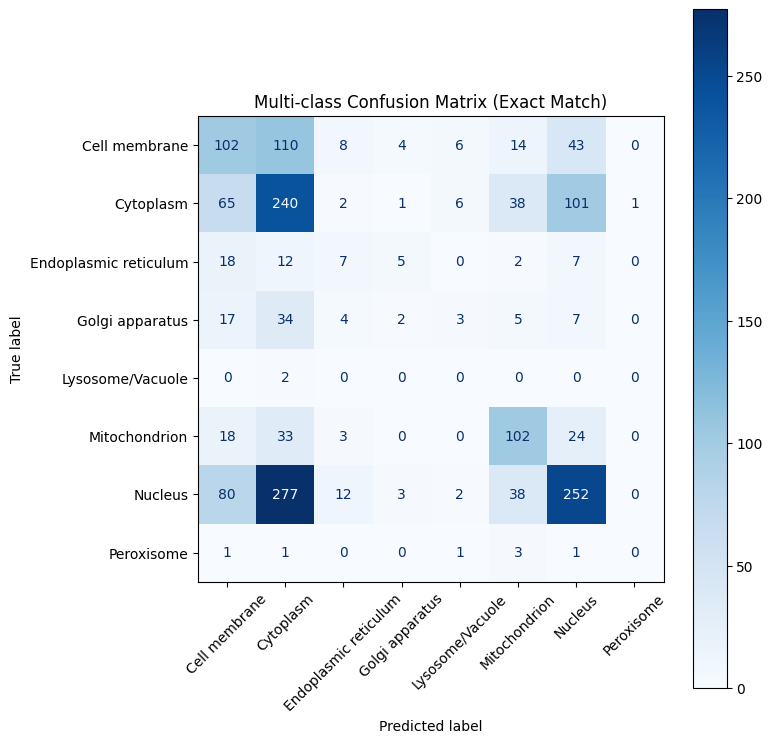

In [15]:
# Convert multi-label to single-label by picking the highest‐scoring class
y_true_single = all_labels.argmax(axis=1)
y_pred_single = all_preds.argmax(axis=1)
cm_multi = confusion_matrix(y_true_single, y_pred_single)
disp_multi = ConfusionMatrixDisplay(cm_multi, display_labels=LABEL_COLS)
fig, ax = plt.subplots(figsize=(8, 8))
disp_multi.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)  # blue colormap here too
ax.set_title('Multi-class Confusion Matrix (Exact Match)')
plt.tight_layout()
plt.show()

## Multi-label classification report

In [16]:
print("Multi-label Classification Report:")
print(classification_report(
    all_labels, all_preds,
    target_names=LABEL_COLS,
    zero_division=0
))

Multi-label Classification Report:
                       precision    recall  f1-score   support

        Cell membrane       0.54      0.18      0.27       287
            Cytoplasm       0.43      0.55      0.48       562
Endoplasmic reticulum       0.16      0.09      0.12        77
      Golgi apparatus       0.25      0.07      0.11        86
     Lysosome/Vacuole       0.00      0.00      0.00         2
        Mitochondrion       0.45      0.56      0.50       196
              Nucleus       0.65      0.64      0.64       893
           Peroxisome       0.00      0.00      0.00         7

            micro avg       0.51      0.50      0.51      2110
            macro avg       0.31      0.26      0.26      2110
         weighted avg       0.52      0.50      0.49      2110
          samples avg       0.47      0.52      0.47      2110



## Exact‐match accuracy

In [17]:
exact_match_acc = accuracy_score(y_true_single, y_pred_single)
print(f"Exact‐match Localization Accuracy: {exact_match_acc:.4f}")

Exact‐match Localization Accuracy: 0.4106
